# Gold recovery

In this project we going to build model to predict percentage of gold recovery from feed. Thecnological process has two main stages:
- flotation (process for selectively separating of hydrophobic materials from hydrophilic). At this stage rougher feed brings to the tank with a liquid. On issue it has refractory ore for further gold recovery treatment and tails.
- primary and secondary cleaning. After this procedure we have final gold particles and new tails. 

Percentage of recovery calculates with the following equation:
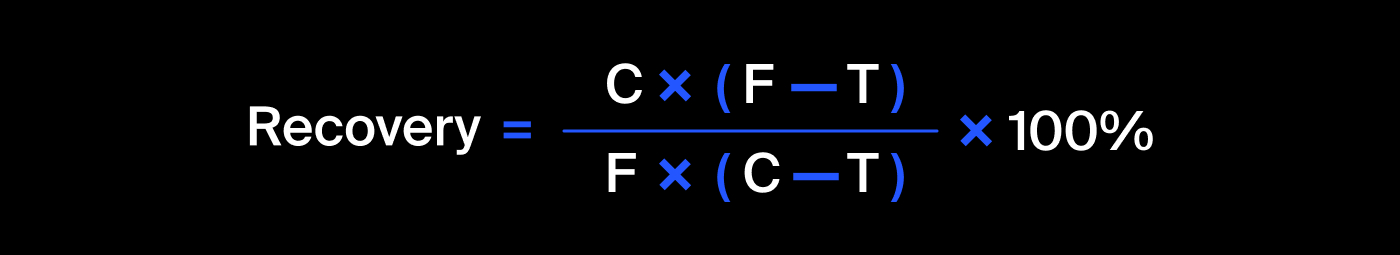

where C - share of gold after flotation or cleaning,
F - share of gold before flotation or cleaning,
T - share of gold in tails after flotation or cleaning

## Exploratory data analysis

In [1]:
#install libraries and load data
!pip install seaborn --upgrade
import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

gold_recovery_train_new = pd.read_csv('/datasets/gold_recovery_train_new.csv')
gold_recovery_test_new = pd.read_csv('/datasets/gold_recovery_test_new.csv')
gold_recovery_full_new = pd.read_csv('/datasets/gold_recovery_full_new.csv')

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 292 kB 2.3 MB/s eta 0:00:01


In [2]:
#check the data
all_data = [gold_recovery_train_new, gold_recovery_test_new, gold_recovery_full_new]
for data in all_data:
    print(data.info())
    print('_________________')
    print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
date                                                  14149 non-null object
final.output.concentrate_ag                           14148 non-null float64
final.output.concentrate_pb                           14148 non-null float64
final.output.concentrate_sol                          13938 non-null float64
final.output.concentrate_au                           14149 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14149 non-null float64
final.output.tail_pb                                  14049 non-null float64
final.output.tail_sol                                 14144 non-null float64
final.output.tail_au                                  14149 non-null float64
primary_cleaner.input.sulfate                         14129 non-null float64
primary_cleaner.input.depressant             

In [3]:
#function to calculate recovery
def rough_recovery(c, f, t):
    return 100 * c * (f - t) / (f * (c -t))

#recalculate rougher.output.recovery 
gold_recovery_train_new['rougher.output.recovery_recount'] = rough_recovery(gold_recovery_train_new['rougher.output.concentrate_au'], gold_recovery_train_new['rougher.input.feed_au'], gold_recovery_train_new['rougher.output.tail_au'])
gold_recovery_train_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 88 columns):
date                                                  14149 non-null object
final.output.concentrate_ag                           14148 non-null float64
final.output.concentrate_pb                           14148 non-null float64
final.output.concentrate_sol                          13938 non-null float64
final.output.concentrate_au                           14149 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14149 non-null float64
final.output.tail_pb                                  14049 non-null float64
final.output.tail_sol                                 14144 non-null float64
final.output.tail_au                                  14149 non-null float64
primary_cleaner.input.sulfate                         14129 non-null float64
primary_cleaner.input.depressant             

In [4]:
#check rougher.output.recovery
mae = mean_absolute_error(gold_recovery_train_new['rougher.output.recovery_recount'], gold_recovery_train_new['rougher.output.recovery'])
mae

1.1455109954099771e-14

Seems like rougher.output.recovery calculated right

In [5]:
#drop a new column
gold_recovery_train_new = gold_recovery_train_new.drop('rougher.output.recovery_recount', axis=1)

In [6]:
# a look at the test dataset
gold_recovery_test_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
date                                          5290 non-null object
primary_cleaner.input.sulfate                 5286 non-null float64
primary_cleaner.input.depressant              5285 non-null float64
primary_cleaner.input.feed_size               5290 non-null float64
primary_cleaner.input.xanthate                5286 non-null float64
primary_cleaner.state.floatbank8_a_air        5290 non-null float64
primary_cleaner.state.floatbank8_a_level      5290 non-null float64
primary_cleaner.state.floatbank8_b_air        5290 non-null float64
primary_cleaner.state.floatbank8_b_level      5290 non-null float64
primary_cleaner.state.floatbank8_c_air        5290 non-null float64
primary_cleaner.state.floatbank8_c_level      5290 non-null float64
primary_cleaner.state.floatbank8_d_air        5290 non-null float64
primary_cleaner.state.floatbank8_d_level      5290 non-null float64
rougher.in

In [7]:
#find training dataset features that are not in test
missed_columns_test = list(set(gold_recovery_train_new.columns) - set(gold_recovery_test_new.columns))
missed_columns_test

['primary_cleaner.output.concentrate_pb',
 'secondary_cleaner.output.tail_ag',
 'final.output.concentrate_pb',
 'rougher.output.concentrate_pb',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'final.output.tail_au',
 'primary_cleaner.output.tail_sol',
 'final.output.tail_pb',
 'final.output.concentrate_au',
 'final.output.tail_ag',
 'final.output.recovery',
 'secondary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_ag',
 'rougher.output.tail_pb',
 'final.output.concentrate_ag',
 'rougher.output.concentrate_sol',
 'secondary_cleaner.output.tail_sol',
 'final.output.concentrate_sol',
 'final.output.tail_sol',
 'rougher.output.tail_sol',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'primary_cleaner.output.concentrate_ag',
 'secondary_cleaner.output.tail_au',
 'rougher.output.concentrate_au',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'rougher.calculation.au_pb_ratio',
 'rougher.output

In [8]:
#columns that miising in train
missed_columns_train = list(set(gold_recovery_full_new.columns) - set(gold_recovery_train_new.columns))
missed_columns_train

[]

### Conclusion

Except target column (final.output.recovery) test dataset is not containing outputs that are gauged or calculated after end of process at each stage. Names o feautures in train and test datasets are the same.


In [9]:
# let's do some preprocessing
def date_index(data):
    data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')
    data = data.set_index('date')
    return data

gold_recovery_train_new = date_index(gold_recovery_train_new)
gold_recovery_test_new = date_index(gold_recovery_test_new)
gold_recovery_full_new = date_index(gold_recovery_full_new)

In [10]:
#find columns with missing values
def cols_with_missing(data):
    return [col for col in data.columns if data[col].isnull().any()]

for data in all_data:
    print(cols_with_missing(data))
    print('number of columns with missing values', len(cols_with_missing(data)))
    print()



['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.tail_pb', 'final.output.tail_sol', 'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant', 'primary_cleaner.input.xanthate', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'primary_cleaner.state.floatbank8_a_air', 'primary_cleaner.state.floatbank8_a_level', 'primary_cleaner.state.floatbank8_b_air', 'primary_cleaner.state.floatbank8_b_level', 'primary_cleaner.state.floatbank8_c_air', 'primary_cleaner.state.floatbank8_c_level', 'primary_cleaner.state.floatbank8_d_air', 'primary_cleaner.state.floatbank8_d_level', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.input.feed_pb', 'rougher.input.feed_rate', 'rougher.input

In [11]:
#check if there are the differences
set(cols_with_missing(gold_recovery_full_new)) - set(cols_with_missing(gold_recovery_train_new))

{'final.output.tail_ag'}

In [12]:
#fill missing values via interpolation
gold_recovery_train_new = gold_recovery_train_new.interpolate()
gold_recovery_full_new = gold_recovery_full_new.interpolate()
gold_recovery_test_new = gold_recovery_test_new.interpolate()

gold_recovery_train_new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           14149 non-null float64
final.output.concentrate_pb                           14149 non-null float64
final.output.concentrate_sol                          14149 non-null float64
final.output.concentrate_au                           14149 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14149 non-null float64
final.output.tail_pb                                  14149 non-null float64
final.output.tail_sol                                 14149 non-null float64
final.output.tail_au                                  14149 non-null float64
primary_cleaner.input.sulfate                         14149 non-null float64
primary_cleaner.input.depressant                      14149 non-null float64
primary_c

## Additional Data Analysis

In [13]:
#select columns with concentrations of metals at each technological stage
def find_mets(names, met):
    concentrate = []
    for name in names:
        if met in name:
            concentrate.append(name)    
    return concentrate

find_mets(gold_recovery_train_new.columns, 'concentrate_ag')

['final.output.concentrate_ag',
 'primary_cleaner.output.concentrate_ag',
 'rougher.output.concentrate_ag']

In [14]:
concentrate_ag = gold_recovery_train_new[find_mets(gold_recovery_train_new.columns, 'concentrate_ag')]
concentrate_pb = gold_recovery_train_new[find_mets(gold_recovery_train_new.columns, 'concentrate_pb')]
concentrate_au = gold_recovery_train_new[find_mets(gold_recovery_train_new.columns, 'concentrate_au')]

In [15]:
def concentrate_to_plot(data):
    sns.set_theme(style="darkgrid")
    plt.figure(figsize=(20,10))
    plt.suptitle('Concentrate distribution on each stage of cleaning', fontsize=15, y=.9)
    plt.ylabel('concentration')
    sns.scatterplot(data=data, palette="tab10", linewidth=0.5)

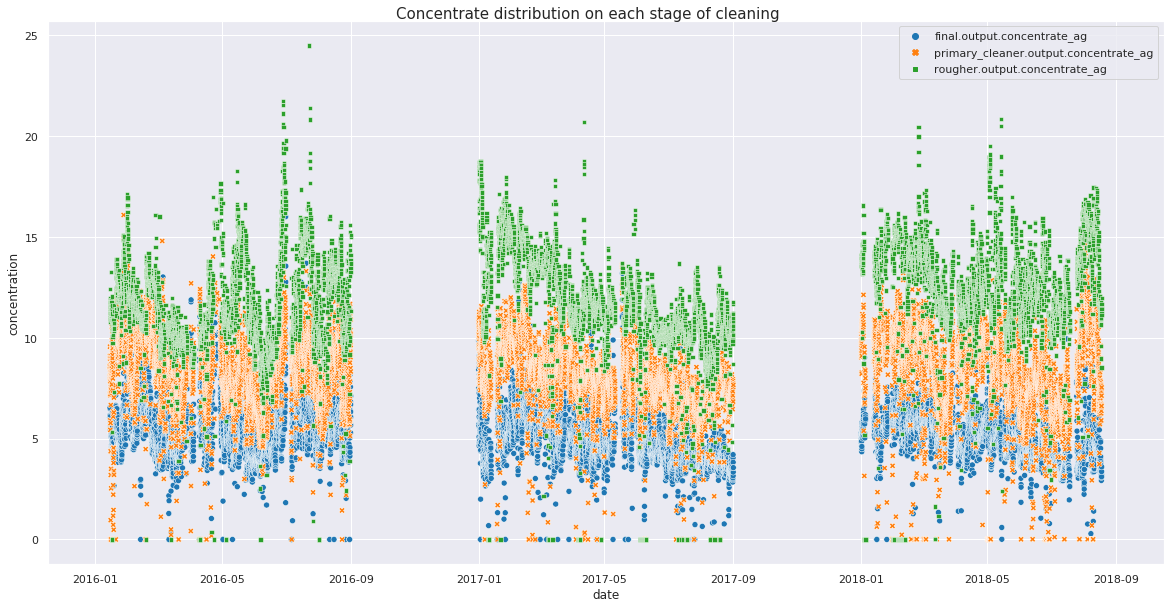

In [16]:
concentrate_to_plot(concentrate_ag)

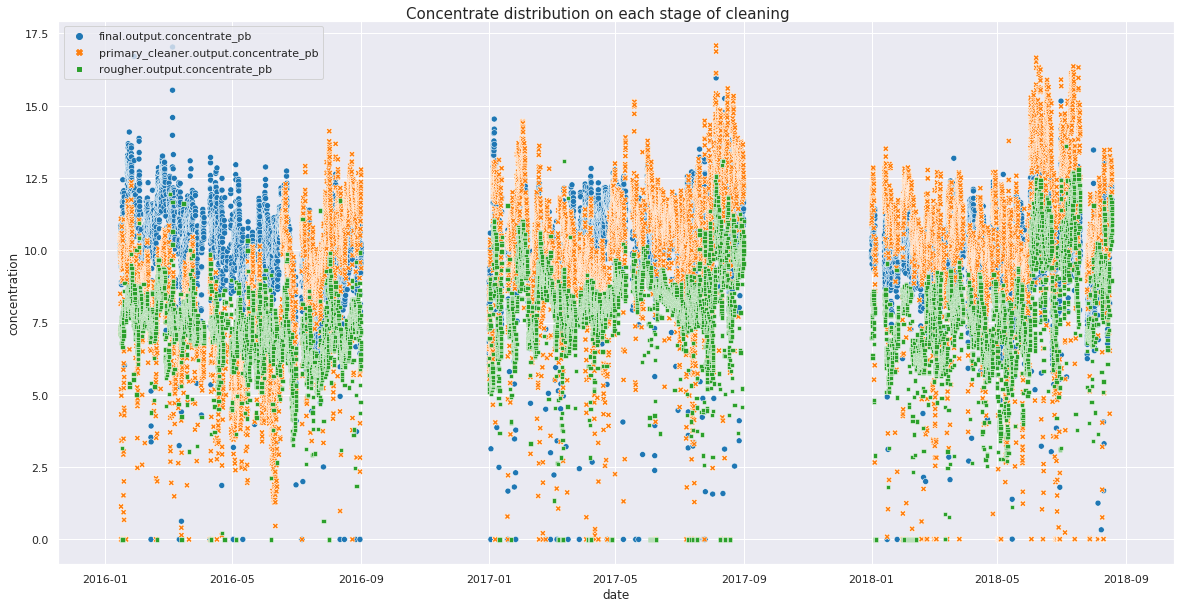

In [17]:
concentrate_to_plot(concentrate_pb)

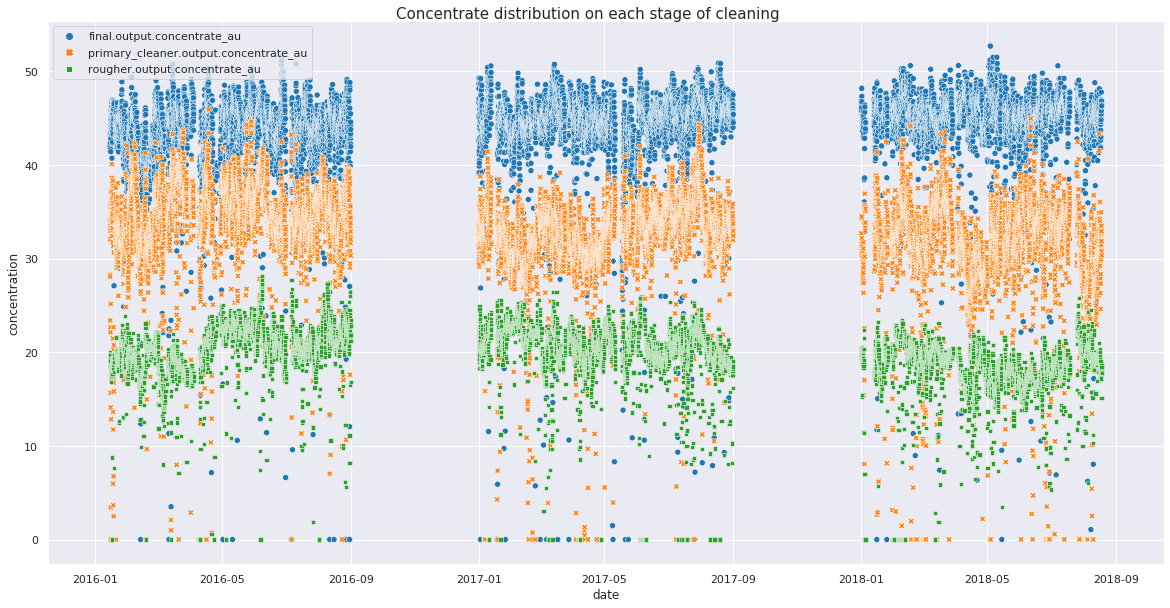

In [18]:
concentrate_to_plot(concentrate_au)

During procedure concentration of Ag is decreasing, concentrations of Au and Pb are increasing. Probably cause of similarity of their physical and chemical properties


In [19]:
#comparison of feed sizes in training and test datasets 
find_mets(gold_recovery_train_new.columns, 'feed_size')

['primary_cleaner.input.feed_size', 'rougher.input.feed_size']

In [20]:
find_mets(gold_recovery_test_new.columns, 'feed_size')

['primary_cleaner.input.feed_size', 'rougher.input.feed_size']

In [21]:
feed_size_train = gold_recovery_train_new[find_mets(gold_recovery_train_new.columns, 'feed_size')]
feed_size_train.describe()

,primary_cleaner.input.feed_size,rougher.input.feed_size
count,14149.000000,14149.000000
mean,7.322310,60.097903
std,0.614062,23.023690
min,1.080000,9.659576
25%,6.960000,48.950593
50%,7.290000,55.269784
75%,7.700000,65.982466
max,10.470000,484.967466


In [22]:
feed_size_test = gold_recovery_full_new[find_mets(gold_recovery_test_new.columns, 'feed_size')]
feed_size_test.describe()

,primary_cleaner.input.feed_size,rougher.input.feed_size
count,19439.000000,19439.000000
mean,7.307078,58.969892
std,0.613509,22.097296
min,1.080000,0.046369
25%,6.940000,47.391173
50%,7.280000,54.544234
75%,7.670000,64.992522
max,15.500000,484.967466


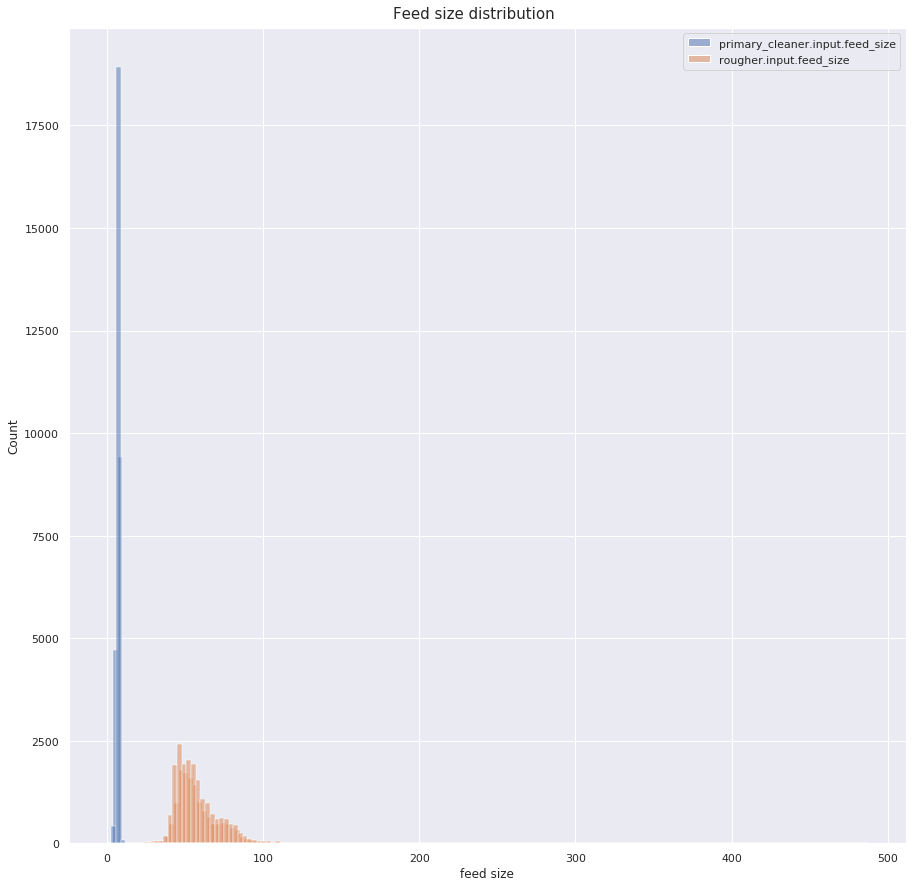

In [23]:
#plot histograms
sns.set_theme(style="darkgrid")
plt.figure(figsize=(15,15))
plt.suptitle('Feed size distribution', fontsize=15, y=.9)
plt.xlabel('feed size')
ax=sns.histplot(
    feed_size_train,
    binwidth=3,
)
sns.histplot(
    feed_size_test,
    binwidth=3, 
    ax=ax
)

Feed size distributions after flotation and primary cleaning in training and test datasets look alike. To check it outwe'll run the T-test. Let's vocabulate null hypothesis as "feed size in training and test datasets are the same". Then alternative hypotesis would be looks like "feed size in training and test datasets are different". Amount of mean values from sample is large enough. Therefore on grounds of Central Limit Theorem the distribution of a sample variable approximates a normal distribution.


In [24]:
#calculate stndard deviation
feed_size_train_rough = feed_size_train['rougher.input.feed_size']
feed_size_train_rough.std()

23.02369028044448

In [25]:
feed_size_test_rough = feed_size_test['rougher.input.feed_size']
feed_size_test_rough.std()

22.0972959967414

In [26]:
def ttest(alpha, dataset1, dataset2):
    alpha = alpha
    results = st.ttest_ind(dataset1, dataset2, equal_var=True)
    print('p-value:', results.pvalue)
    if results.pvalue < alpha:
        print('Reject null hypothesis')
    else:
        print('Fail to reject null hypothesis') 
        
ttest(0.05, feed_size_train_rough, feed_size_test_rough)

p-value: 5.69166202978067e-06
Reject null hypothesis


In [27]:
feed_size_train_primary = feed_size_train['primary_cleaner.input.feed_size']
feed_size_train_primary.std()

0.6140622641450755

In [28]:
feed_size_test_primary = feed_size_test['primary_cleaner.input.feed_size']
feed_size_test_primary.std()

0.6135089773036972

In [29]:
ttest(0.05, feed_size_train_primary, feed_size_test_primary)

p-value: 0.024725491546568452
Reject null hypothesis


### Conclusion

Probability that difference between feed sizes before flotation could not have occurred just by random chance is 0.0005%. Before primary cleaning probability of their difference is 2.4%.


In [30]:
#explore the summary concentration of metals during th process
concentrate_sol = gold_recovery_train_new[find_mets(gold_recovery_train_new.columns, 'concentrate_sol')]
whole_concentrates = concentrate_ag.join(concentrate_pb).join(concentrate_au)
whole_concentrates.head()

,final.output.concentrate_ag,primary_cleaner.output.concentrate_ag,rougher.output.concentrate_ag,final.output.concentrate_pb,primary_cleaner.output.concentrate_pb,rougher.output.concentrate_pb,final.output.concentrate_au,primary_cleaner.output.concentrate_au,rougher.output.concentrate_au
date,,,,,,,,,
2016-01-15 00:00:00,6.055403,8.547551,11.500771,9.889648,10.389648,7.101074,42.192020,34.174427,19.793808
2016-01-15 01:00:00,6.029369,8.558743,11.615865,9.968944,10.497069,7.278807,42.701629,34.118526,20.050975
2016-01-15 02:00:00,6.055926,8.603505,11.695753,10.213995,10.354494,7.216833,42.657501,33.969464,19.737170
2016-01-15 03:00:00,6.047977,7.221879,11.915047,9.977019,8.496563,7.175616,42.689819,28.260743,19.320810
2016-01-15 04:00:00,6.148599,9.089428,12.411054,10.142511,9.986786,7.240205,42.774141,33.044932,19.216101


In [31]:
cleaning_stages = ['rougher', 'primary', 'final']
concentrates = pd.DataFrame()

for stage in cleaning_stages:
    find_mets(whole_concentrates.columns, stage)
    concentrates[find_mets(whole_concentrates.columns, stage)] = whole_concentrates[find_mets(whole_concentrates.columns, stage)]
    concentrates['total_concentration on {} stage'. format(stage)] = concentrates[find_mets(whole_concentrates.columns, stage)].sum(axis=1)
    concentrates = concentrates.drop(find_mets(whole_concentrates.columns, stage), axis=1)

concentrates.head()    


,total_concentration on rougher stage,total_concentration on primary stage,total_concentration on final stage
date,,,
2016-01-15 00:00:00,38.395653,53.111627,58.137072
2016-01-15 01:00:00,38.945647,53.174338,58.699942
2016-01-15 02:00:00,38.649756,52.927464,58.927421
2016-01-15 03:00:00,38.411473,43.979185,58.714815
2016-01-15 04:00:00,38.867359,52.121146,59.065251


In [32]:
concentrates.describe()  

,total_concentration on rougher stage,total_concentration on primary stage,total_concentration on final stage
count,14149.000000,14149.000000,14149.000000
mean,38.880325,50.156252,59.278554
std,6.927062,7.958490,5.707729
min,0.000000,0.000000,0.000000
25%,37.925621,49.631769,59.201505
50%,39.860389,51.792243,60.260341
75%,41.796805,53.439969,61.054829
max,55.568687,60.269003,64.968881


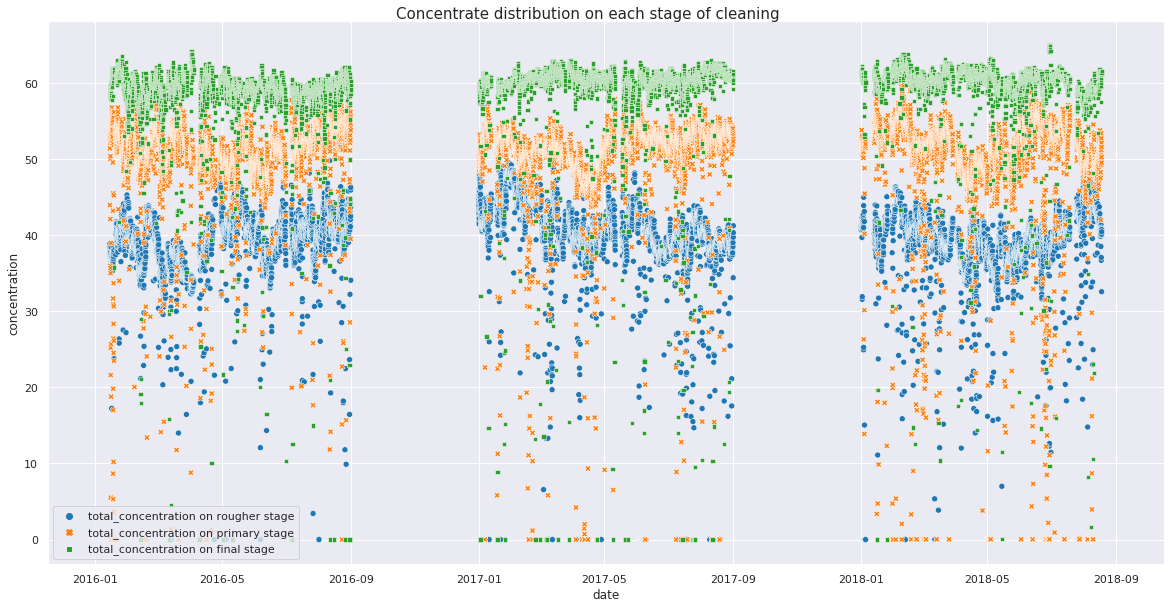

In [33]:
concentrate_to_plot(concentrates)

In [34]:
#drop null concentrations
gold_recovery_train_new = gold_recovery_train_new.drop(gold_recovery_train_new[(gold_recovery_train_new['rougher.output.concentrate_ag'] == 0) & (gold_recovery_train_new['rougher.output.concentrate_au'] == 0) & (gold_recovery_train_new['rougher.output.concentrate_pb'] == 0)].index)
gold_recovery_full_new = gold_recovery_full_new.drop(gold_recovery_full_new[(gold_recovery_full_new['rougher.output.concentrate_ag'] == 0) & (gold_recovery_full_new['rougher.output.concentrate_au'] == 0) & (gold_recovery_full_new['rougher.output.concentrate_pb'] == 0)].index)





### Conclusion

Summary concentration of metals is increasing during th process. Mainly on account of Au


## Machine Learning

In [35]:
#brake off features and targets from dataset
features_columns = gold_recovery_test_new.columns
targets_columns = ['rougher.output.recovery', 'final.output.recovery']

features_train = gold_recovery_train_new[features_columns].reset_index(drop=True)
target_train = gold_recovery_train_new[targets_columns].reset_index(drop=True)
target_train.columns = [0, 1]

features_test = gold_recovery_test_new[features_columns].reset_index(drop=True)
target_test = gold_recovery_full_new[targets_columns].loc[gold_recovery_test_new.index].reset_index(drop=True)
target_test.columns = [0, 1]

In [36]:
#check samples sizes
samples = [features_train, target_train, features_test, target_test]
for sample in samples:
    print(sample.shape)

(13852, 52)
(13852, 2)
(5290, 52)
(5290, 2)


In [37]:
#напишем функцию для вычисления итоговой sMAPE
def smape_1(y_true, y_pred):
    error = (y_true - y_pred).abs()
    scale = (y_true.abs() + y_pred.abs()) / 2
    result = (error / scale).mean()
    return result*100
 

def smape(y_true, y_pred):
    y_true = pd.DataFrame(data = y_true).reset_index(drop=True)
    y_pred = pd.DataFrame(data=y_pred)
    rougher = smape_1(y_true.iloc[:, 0], y_pred.iloc[:, 0])
    final = smape_1(y_true.iloc[:, 1], y_pred.iloc[:, 1])
    return 0.25 * rougher + 0.75 * final

my_scorer = make_scorer(smape, greater_is_better = False)

Define a metric as following

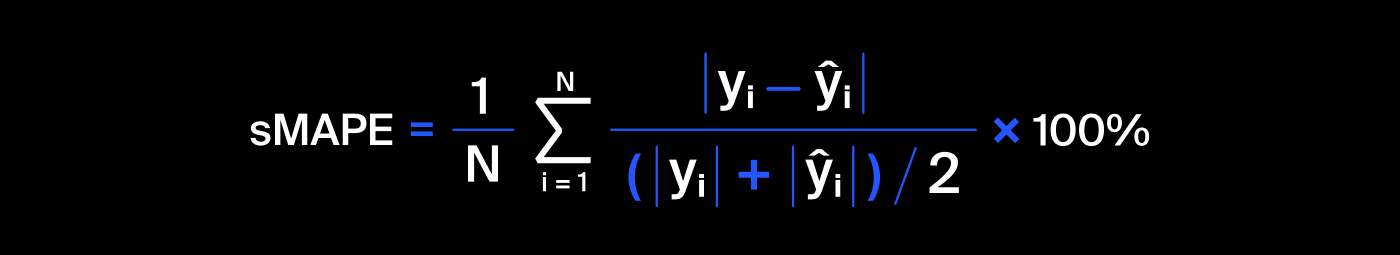

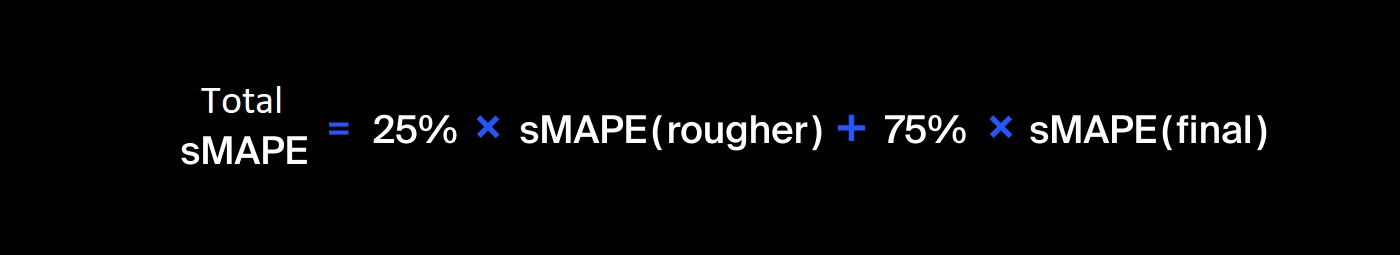

In [38]:
my_scorer = make_scorer(smape, greater_is_better=False)

In [39]:
#define pipeline with LinearRegression model
my_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

In [40]:
#run cross-validation
scores = cross_val_score(my_pipeline,features_train, target_train,
                              cv=5,
                              scoring=my_scorer)

print('Symmetric mean absolute percentage error:', -1 * scores.mean(), "%")

Symmetric mean absolute percentage error: 11.046204024669441 %


In [41]:
#check on the test
print('Symmetric mean absolute percentage error on test sample:', smape(
    target_test, my_pipeline.fit(features_train, target_train).predict(features_test)), "%")


Symmetric mean absolute percentage error on test sample: 8.836804367068009 %


In [42]:
#define pipeline with RandomForest model
my_pipeline_forest = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(max_depth=7, n_estimators=70, random_state=12345))
])

In [43]:
#find optimal hyperparameters
# distributions = dict(model__max_depth = range(7,10, 1), 
#                      model__n_estimators = range(70, 100, 10)
#                     )

# clf = RandomizedSearchCV(my_pipeline_forest, distributions, random_state=12345)
# search = clf.fit(features_train, target_train)

# print('Best hyperparametres', search.best_params_)

In [44]:
#run cross-validation
scores = cross_val_score(my_pipeline_forest,features_train, target_train,
                              cv=5,
                              scoring=my_scorer)

print('Symmetric mean absolute percentage error:', -1 * scores.mean(), "%")

Symmetric mean absolute percentage error: 10.032796608150576 %


In [45]:
#check on the test
print('Symmetric mean absolute percentage error on test sample:', smape(
    target_test, my_pipeline_forest.fit(features_train, target_train).predict(features_test)), "%")


Symmetric mean absolute percentage error on test sample: 8.849175018633423 %


In [46]:
#run Dummy test
dummy_regr = DummyRegressor(strategy='mean')
dummy_regr.fit(features_train, target_train)

print('Dummy score:', smape(dummy_regr.predict(features_test), target_test), "%")

Dummy score: 9.007052456833447 %


### Conclusion

In this project we've built model to predict percentage gold recovery from feed. So it could help to improve gold extraction process, make it more efficiently. 
